## Slice wants to analyze the  customers’ retention and churn pattern 
1. Define Customer Cohorts. Group the customers in the dataset into cohorts based on their first-order characteristics and the month of their first order. These cohorts should be actionable, helping lead to business insights. Make hypotheses about how churn rates will differ across cohorts, which you can reflect on after performing your analysis. 
2. What are the Customer Retention rate and Churn rate for the customer cohorts over time? Is there a significant difference in retention/churn based on different promotions. 
 
3. What is the dollar value (restaurant_total) retention rate overtime for each cohort? What’s the insights you can derive from the answers of this and the previous question? 
 
4. Are there any caveats to this analysis using only the provided data? What other data would be ideal to have? 

## 1. User Statistics
    1. Who made at least 2 purchases?
         * 78% made the second purchase
    2. For users made 2nd purchase, how long before second purchase?
         * 9% made the second purchase in same day
         * 31% made the second purchase in a week
         * 65% made the second purchase in a month
    3. What is average/median order amount?
         * $31/$27
    4. What is average/median monthly order count?
         * 1.45/1
    5. What is average/median order frequency?
         * monthly
    6. What is average/median life time?
         * 7 months/8 months


## 2. Revenue Statistics
    1. Which State and city made up most of revenue?
        * NY, NJ, PA, MA are top 4 revenue cities, altogether made up of 57% revenue.
        * Low density city made up of 70% revenue.
    2. Which Source made up most of revenue? 
        * ios app made up of 65% revenue.
        * partner website made up of 22% revenue.
    3. Which shipping and payment types made up most of revenue? 
        * Delivery made up of 83% revenue.
        * Credit card made up of 87% revenue.
        * 75% revenue are delivery using credit card
    4. What time(month/weekday/hour) do users use Slice more?

## 3. Retention Analysis
    1. Overall retention chart: monthly and weekly (2)
    2. retention chart by cohort
        * first order using credit card and choosing delivery service has higher monthly retention rate.
        * source from app and partner button has higher monthly retention rate.
        * locations from top sale cities have higher monthly retention rate. Top 10 cities with most revenues.
            * Staten Island
            * Philadelphia
            * Brooklyn
            * Elkridge
            * Chicago
            * Las Vegas
            * Nashville
            * Bristol
            * Cambridge

## 4. Promotion Impact
    1. Coupon 1 (promo_value=1) were used in most cities (136 cities) while coupon 5 (promo_value=5) were used in only 64 cities.
    2. Coupon 1 was the most effective to keep a better monthly retention rate.
    3. Coupon 1 works the most effective in top sales and high density cities.

## 5. Revenue

## 6. Other data to improve the analysis
    1. Geography data
        * How many Pizza stores?
        * competitors: How many other restaurant/deli?
        * Location zipcode density, population.
        * Location important landmark, eg. college town.
    2. Customer demographic data
        * Age
        * Gender
        * Birthday
    3. Order time
        * Which hours ordered the most? order for lunch, dinner or late night snack?
        * Whish week day ordered the most?
        * Which season/month order the most?
        * Whether there is spike in some holiday?
    4. Shopping behavior
        * Tenure
        * Total order amount in different time windows
        * Purchase frequency
        * Average order value
        * Sensitivity to discount 
    5. Marketing campaign
        * Campaign impression, CTR, cost
    6. App experience
        * Clicks
        * Conversion Rate
        * Bounce Rate
        * App ratings
    7. Service experience
        * Delivery time
        * Service ratings 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### Clean Data
* Create new features in transaction Data
* Join ZIP code data to get more geo information
* Extract first time purchase, second time purchase and long time purchase behavior

In [2]:
trans_data = pd.read_csv('C:/Users/cheng/Desktop/Job Upgrade/Slice/churn_homework - churn_homework_orders.csv')

# We have one year data. To get a full monthly view, we subtract 12 days from purchased date
trans_data = trans_data.drop_duplicates()
print(trans_data.date_purchased.min(), trans_data.date_purchased.max())
trans_data['date_purchased'] = pd.to_datetime(trans_data['date_purchased'], errors='coerce')
trans_data['date_purchased_shft'] = trans_data['date_purchased']-datetime.timedelta(days=12)
print(trans_data.date_purchased.min(), trans_data.date_purchased.max())
print(trans_data.date_purchased_shft.min(), trans_data.date_purchased_shft.max())

# Extract month, weekday and hour
trans_data['shipping_payment'] = trans_data['shipping_type'] + '_'+ trans_data['payment_method']
trans_data['order_month_shft'] = trans_data['date_purchased_shft'].dt.to_period('M')
trans_data['order_weekday'] = trans_data['date_purchased'].dt.weekday
trans_data['order_hour'] = trans_data['date_purchased'].dt.hour
trans_data['cohort_start'] = trans_data.groupby('customer')['date_purchased_shft'].transform('min').dt.to_period('M')
trans_data['latest_active'] = trans_data.groupby('customer')['date_purchased_shft'].transform('max').dt.to_period('M')

2019-03-13T06:36:53.000Z 2020-03-12T21:04:44.000Z
2019-03-13 06:36:53+00:00 2020-03-12 21:04:44+00:00
2019-03-01 06:36:53+00:00 2020-02-29 21:04:44+00:00


In [3]:
uszips = pd.read_csv('C:/Users/cheng/Desktop/Job Upgrade/Slice/uszips.csv')
zipcodelst = ['zip','lat','lng','population','density','county_name','city']
trans_data = pd.merge(trans_data,uszips[zipcodelst], left_on='postal_code', right_on='zip', how='left')

In [4]:
# Get customer first time purchase data
first_time_purch = pd.DataFrame(trans_data.groupby(['customer']) \
                                          .agg({'date_purchased': 'min'}) \
                                          .reset_index(drop=False))

customer_first_data = pd.merge(trans_data, first_time_purch, on=['date_purchased','customer'], how='inner')
customer_first_data.rename(columns = {'order_id': 'first_order_id', \
                                    'date_purchased': 'first_date_purchased', \
                                    'date_purchased_shft': 'first_date_purchased_shft',\
                                    'source':'first_source', \
                                    'shipping_type':'first_shipping_type', \
                                    'payment_method':'first_payment_method', \
                                    'shipping_payment': 'first_shipping_payment',\
                                    'promo_value': 'first_promo_value', \
                                    'restaurant_total': 'first_restaurant_total', \
                                    'shops_id': 'first_shops_id', \
                                    'State': 'first_State', \
                                    'postal_code': 'first_postal_code', \
                                    'order_month_shft':'first_order_month_shft', \
                                    'order_weekday':'first_order_weekday', \
                                    'order_hour':'first_order_hour', \
                                    'zip':'first_zip', \
                                    'lat':'first_lat', \
                                    'lng':'first_lng', \
                                    'population':'first_population', \
                                    'density':'first_density', \
                                    'county_name':'first_county_name', \
                                    'city':'first_city'}, inplace = True)
first_feature_lst = ['first_order_id', 'first_source', 'first_date_purchased', 'first_shipping_type', 'first_payment_method', 'first_promo_value', \
                     'first_restaurant_total', 'customer', 'first_shops_id', 'first_State', 'first_postal_code', 'first_date_purchased_shft', 'first_shipping_payment', \
                     'first_order_month_shft', 'first_order_weekday', 'first_order_hour','first_zip','first_lat','first_lng','first_population','first_density', \
                     'first_county_name', 'first_city']
customer_first_data= customer_first_data[first_feature_lst]

In [5]:
# Get customer second time purchase data
# group by name and convert dates into individual columns
second_purch = trans_data.sort_values("date_purchased", ascending=True). \
                    groupby("customer")["date_purchased_shft"].apply(list).apply(pd.Series).reset_index()
# truncate and rename columns
second_purch = second_purch[["customer", 0, 1]]
second_purch.columns = ["customer", "first_purch", "second_purch"]
second_purch['to_second'] = (second_purch['second_purch'] - second_purch['first_purch']).apply(attrgetter('days'))

In [6]:
# Get customer long term purchase data
customer_long_data = trans_data.groupby(['customer','cohort_start','latest_active']) \
                               .agg(order_count=('order_id','count'), \
                                    order_total=('restaurant_total','sum'), \
                                    order_avg=('restaurant_total','mean')) \
                               .reset_index(drop=False)
customer_long_data['enrolled_month'] = ((customer_long_data['latest_active']-customer_long_data['cohort_start']).apply(attrgetter('n')))+1
end_month = pd.Period('3/1/2020', freq='M')
customer_long_data['cohort_num'] = (end_month-customer_long_data['cohort_start']).apply(attrgetter('n'))
customer_long_data['order_per_month'] = customer_long_data['order_count']/customer_long_data['enrolled_month']
customer_long_data['order_frequency'] = customer_long_data['enrolled_month']/customer_long_data['order_count']
#customer_long_data = customer_long_data[['customer','order_count','order_total','order_avg','enrolled_month','order_per_month']]
customer_long_data.head(5)

,customer,cohort_start,latest_active,order_count,order_total,order_avg,enrolled_month,cohort_num,order_per_month,order_frequency
0,2012144625,2019-03,2019-12,4,148.52,37.130000,10,12,0.400000,2.500000
1,2012383018,2019-03,2020-01,6,192.54,32.090000,11,12,0.545455,1.833333
2,2012416238,2019-03,2020-02,36,470.84,13.078889,12,12,3.000000,0.333333
3,2012596116,2019-07,2019-07,1,29.82,29.820000,1,8,1.000000,1.000000
4,2012904791,2019-03,2020-01,38,968.52,25.487368,11,12,3.454545,0.289474


In [7]:
cust_complete = pd.merge(customer_first_data, second_purch, on='customer', how='left')
cust_complete = pd.merge(customer_long_data, cust_complete, on='customer', how='left')
trans_cust_complete = pd.merge(trans_data, cust_complete, on='customer', how='left')

In [8]:
trans_cust_complete['cohort'] = trans_cust_complete.groupby('customer')['date_purchased_shft'].transform('min').dt.to_period('M')
trans_cust_complete['period_number'] = ((trans_cust_complete.order_month_shft - trans_cust_complete.cohort).apply(attrgetter('n')))
customer_churn = trans_cust_complete.pivot_table(index=['customer','cohort'], columns = 'period_number',values = 'order_id', aggfunc='count', fill_value=0)
customer_churn['churn_1'] = customer_churn[1].apply(lambda x: 'Churn' if x == 0 else 'Active')
#customer_churn['churn_2'] = customer_churn[1].apply(lambda x: 'Churn' if x == 0 else 'Active')
churn_analysis = pd.merge(customer_churn, cust_complete, on='customer', how='left')
print(churn_analysis.groupby('churn_1').agg({'first_density':'mean','first_population':'mean'}))

first_density  first_population
churn_1                                 
Active     3223.135760      33162.842584
Churn      2427.346033      32821.350965


## User Statistics
* ### Who made at least 2 purchases?
    * 78% made the second purchase
* ### For users made 2nd purchase, how long before second purchase?
    * 9% made the second purchase in same day
    * 31% made the second purchase in a week
    * 65% made the second purchase in a month
* ### What is average/median order amount?
    * $31
    * $27
* ### What is average/median monthly order count?
    * 1.45
    * 1
* ### What is average/median order frequency?
    * monthly
* ### What is average/median life time?
    * 7 months
    * 8 months

In [9]:
# how many are recurred users
print(round(len(cust_complete[cust_complete.order_count>=2])/len(cust_complete)*100,2), len(cust_complete[cust_complete.order_count>=2]), '\n')

# how many are recurred users who enrolled at least 3 months
customer_3_month = cust_complete[cust_complete['cohort_num']>=3]
print(round(len(customer_3_month[customer_3_month.order_count>=2])/len(customer_3_month)*100,2), len(customer_3_month[customer_3_month.order_count>=2]), '\n')

# How long does a customer make the second purchase
print(cust_complete.to_second.mean(), '\n', (cust_complete.to_second.quantile([0.25, 0.5, 0.75])), '\n')
print(round(len(cust_complete[cust_complete.to_second<=0])/len(cust_complete[cust_complete.order_count>=2]),2), '\n',\
      round(len(cust_complete[cust_complete.to_second<=7])/len(cust_complete[cust_complete.order_count>=2]),2), '\n', \
      round(len(cust_complete[cust_complete.to_second<=21])/len(cust_complete[cust_complete.order_count>=2]),2), '\n',\
      round(len(cust_complete[cust_complete.to_second<=28])/len(cust_complete[cust_complete.order_count>=2]),2), '\n')

# What is average/median order amount
print(round(trans_cust_complete.restaurant_total.mean(),2), round(trans_cust_complete.restaurant_total.median(),2), '\n')

# What is average/median monthly order count?
print(round(cust_complete.order_per_month.mean(),2), round(cust_complete.order_per_month.median(),2), '\n')

# What is average/median order frequency?
print(round(cust_complete.order_frequency.mean(),2), round(cust_complete.order_frequency.median(),2), '\n')

# What is average/median life time?
print(round(cust_complete[cust_complete['cohort_num']>=6].enrolled_month.mean(),2), round(cust_complete[cust_complete['cohort_num']>=6].enrolled_month.median(),2), '\n')

73.96 1849 

77.55 1817 

36.00162249864792 
 0.25     6.0
0.50    17.0
0.75    44.0
Name: to_second, dtype: float64 

0.09 
 0.31 
 0.56 
 0.65 

31.31 27.28 

1.45 1.0 

1.01 1.0 

7.07 8.0 



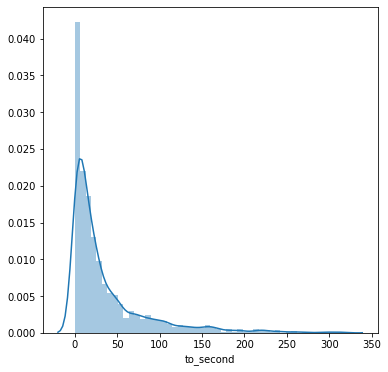

In [10]:
plt.figure(figsize=(6, 6))
sns.distplot(cust_complete[cust_complete.to_second.notnull()]['to_second'])

## Revenue Statistics
* ### Which State and city made up most of revenue?
    * NY, NJ, PA, MA are top 4 revenue cities, altogether made up of 57% revenue.
    * Low density city made up of 70% revenue.
* ### Which Source made up most of revenue? 
    * ios app made up of 65% revenue.
    * partner website made up of 22% revenue.
* ### Which shipping and payment types made up most of revenue? 
    * Delivery made up of 83% revenue.
    * Credit card made up of 87% revenue.
    * 75% revenue are delivery using credit card


In [11]:
# Pull order statistics by city
uszips['land'] = uszips['population']/uszips['density']
uszips = uszips.replace([np.inf, -np.inf], np.nan)
uszips['land'] = uszips['land'].fillna(0)
city_density = pd.DataFrame(uszips.groupby(['city']) \
                                   .agg(population=('population', 'sum'), \
                                        land=('land', 'sum')) \
                                   .reset_index(drop=False))
city_density['density'] = city_density['population']/city_density['land']
#city_density['density'] = city_density['density'].fillna(0)

order_city = pd.DataFrame(trans_cust_complete.groupby(['city']) \
                                             .agg(customer_count=('customer', 'nunique'), \
                                                  order_count=('order_id','count'), \
                                                  order_total=('restaurant_total','sum'), \
                                                  order_avg=('restaurant_total','mean')) \
                                             .reset_index(drop=False) \
                                             .rename(columns={'customer_count':'NO. Customer', \
                                                            'order_count':'No. Orders', \
                                                            'order_total':'Sales', \
                                                            'order_avg':'Order Average Value'})
                                             .sort_values(['Sales'],ascending=False))
#order_city['Sales Percentage'] = (100. * order_city.Sales / order_city.Sales.sum()).round(1).astype(str) + '%'
order_city['Sales Percentage'] = (100. * order_city.Sales / order_city.Sales.sum())
order_city = pd.merge(order_city,city_density, on='city', how='left')
order_city.head(10)

,city,NO. Customer,No. Orders,Sales,Order Average Value,Sales Percentage,population,land,density
0,New York,68,915,32087.43,35.068230,4.130174,1621814,58.405610,27768.120387
1,Staten Island,42,659,19524.26,29.627102,2.513089,474101,149.093841,3179.883198
2,Philadelphia,63,808,18973.45,23.481993,2.442191,1608542,1842.590182,872.978710
3,Brooklyn,55,607,15947.68,26.272949,2.052726,2661848,1488.117850,1788.734676
4,Elkridge,10,123,9625.05,78.252439,1.238900,32496,46.356633,701.000000
5,Chicago,28,239,7971.85,33.355021,1.026107,2702217,574.481494,4703.749431
6,Las Vegas,26,192,7260.05,37.812760,0.934486,1564909,10425.256618,150.107480
7,Nashville,19,258,7239.28,28.059225,0.931813,512376,3516.396150,145.710545
8,Bristol,18,194,5766.57,29.724588,0.742251,207380,3040.510916,68.205642
9,Cambridge,6,34,5760.56,169.428235,0.741478,187873,4394.340976,42.753396


In [12]:
print((order_city['Sales Percentage'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])), '\n')
print((order_city['density'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])), '\n')

0.10    0.003653
0.25    0.009034
0.50    0.030119
0.75    0.092637
0.90    0.197202
Name: Sales Percentage, dtype: float64 

0.10      33.881536
0.25      84.064348
0.50     292.922604
0.75     945.027941
0.90    1947.130000
Name: density, dtype: float64 



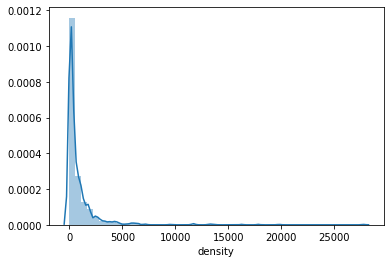

In [13]:
#ax = sns.scatterplot(x=order_city['Sales Percentage'], y=order_city['density'], data=order_city)
ax = sns.distplot(order_city['density'])

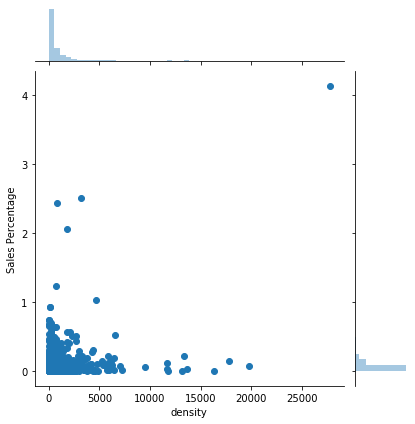

In [14]:
#ax = sns.distplot(order_city['Sales Percentage'])
#ax = sns.distplot(order_city['density'])
ax = sns.jointplot(y=order_city['Sales Percentage'], x=order_city['density'], data=order_city)

#### Classify cities into 4 groups by sales and denstiy
* Top sales with high density: sales (>=3%) and density (>=1000)
* Top sales with low density: sales (>=3% ) and density (<1000)
* Low sales with high density: sales (<3%) and density (>=1000)
* Low sales with low density: sales (<3%) and density (<1000)

In [15]:
def city_tier(row):
    if row['Sales Percentage']>=0.03 and row['density']>=1000:
        val='topsal_highden'
    elif row['Sales Percentage']>=0.03 and row['density']<1000:
        val='topsal_lowden'
    elif row['Sales Percentage']<0.03 and row['density']>=1000:
        val='lowsal_highden'
    else:       
        val='lowsal_lowden'
    return val
order_city['city_tier'] = order_city.apply(city_tier, axis=1)

In [16]:
order_city.head(10)

,city,NO. Customer,No. Orders,Sales,Order Average Value,Sales Percentage,population,land,density,city_tier
0,New York,68,915,32087.43,35.068230,4.130174,1621814,58.405610,27768.120387,topsal_highden
1,Staten Island,42,659,19524.26,29.627102,2.513089,474101,149.093841,3179.883198,topsal_highden
2,Philadelphia,63,808,18973.45,23.481993,2.442191,1608542,1842.590182,872.978710,topsal_lowden
3,Brooklyn,55,607,15947.68,26.272949,2.052726,2661848,1488.117850,1788.734676,topsal_highden
4,Elkridge,10,123,9625.05,78.252439,1.238900,32496,46.356633,701.000000,topsal_lowden
5,Chicago,28,239,7971.85,33.355021,1.026107,2702217,574.481494,4703.749431,topsal_highden
6,Las Vegas,26,192,7260.05,37.812760,0.934486,1564909,10425.256618,150.107480,topsal_lowden
7,Nashville,19,258,7239.28,28.059225,0.931813,512376,3516.396150,145.710545,topsal_lowden
8,Bristol,18,194,5766.57,29.724588,0.742251,207380,3040.510916,68.205642,topsal_lowden
9,Cambridge,6,34,5760.56,169.428235,0.741478,187873,4394.340976,42.753396,topsal_lowden


In [17]:
trans_cust_complete = pd.merge(trans_cust_complete,order_city[['city','city_tier']], on='city', how='left')
order_city_tmp = order_city[['city','city_tier']]
order_city_tmp.rename(columns={'city_tier': 'first_city_tier'}, inplace=True)
trans_cust_complete = pd.merge(trans_cust_complete,order_city_tmp, left_on='first_city', right_on='city', how='left')

Text(0.5, 1.0, 'Number of Orders by State 2019/03-2020/03')

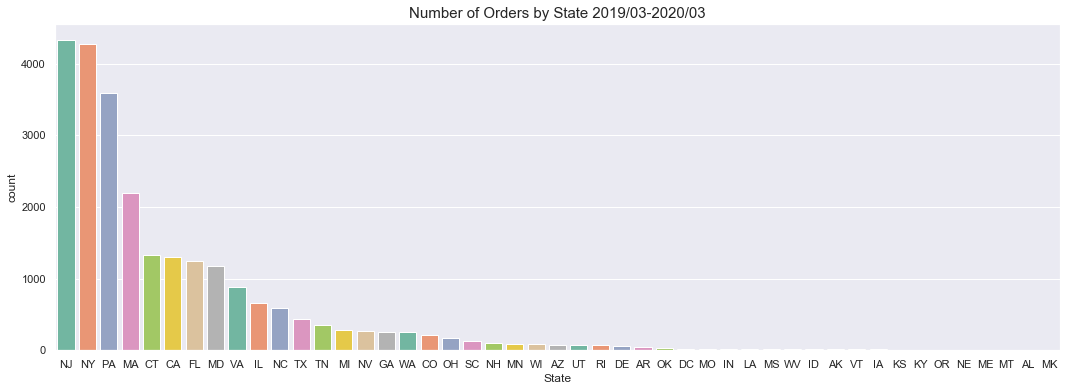

In [49]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(rc={'figure.figsize':(18,6)})
ax = sns.countplot(x="State", data=trans_cust_complete, \
                   order = trans_cust_complete.State.value_counts().index, \
                   palette="Set2") 
ax.set_title('Number of Orders by State 2019/03-2020/03', fontsize=15)

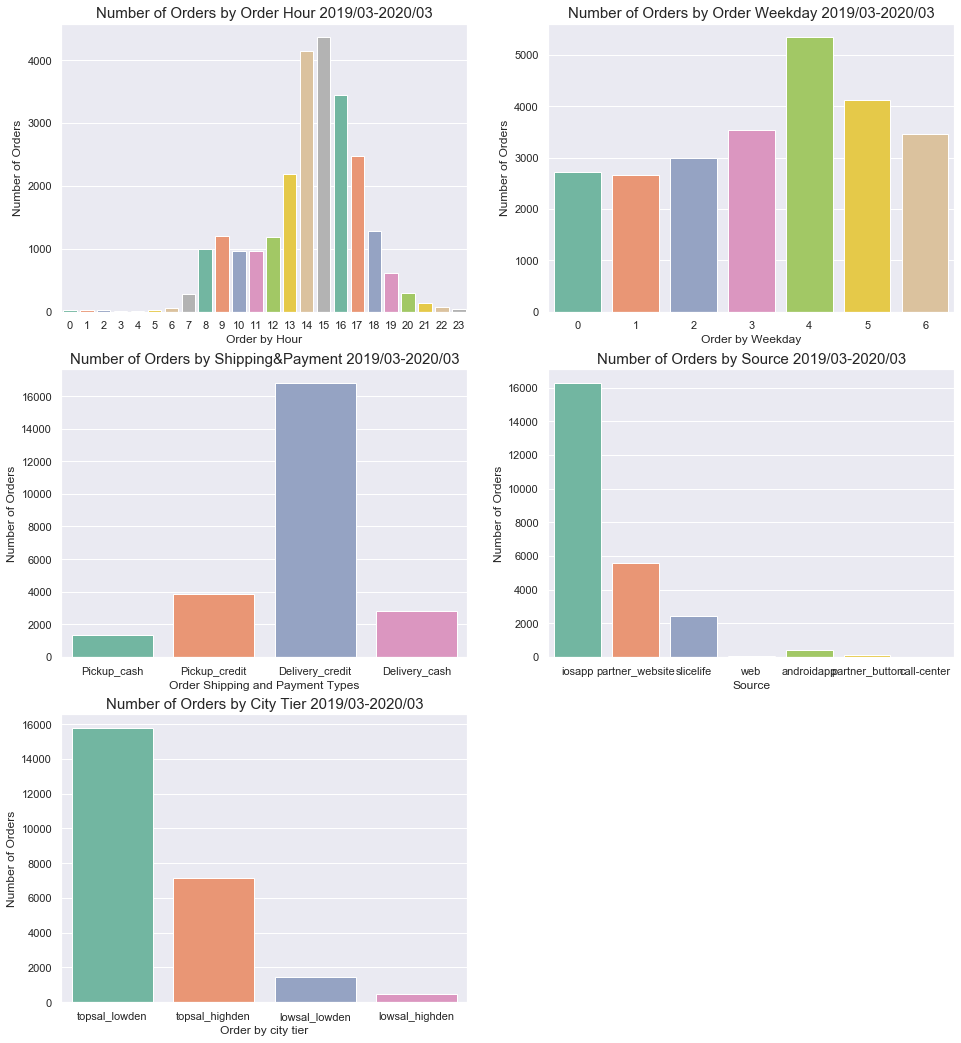

In [51]:
f = plt.figure(figsize=(16, 18))
gs = f.add_gridspec(3, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(x="order_hour", data=trans_cust_complete, palette="Set2")
    ax.set(xlabel='Order by Hour', ylabel='Number of Orders')
    ax.set_title('Number of Orders by Order Hour 2019/03-2020/03', fontsize=15)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.countplot(x="order_weekday", \
                  data=trans_cust_complete, palette="Set2")
    ax.set(xlabel='Order by Weekday', ylabel='Number of Orders')
    ax.set_title('Number of Orders by Order Weekday 2019/03-2020/03', fontsize=15)    
  
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.countplot(x="shipping_payment", \
                  #order=['2019-03','2019-04','2019-05','2019-06','2019-07','2019-08',\
                  #       '2019-09','2019-10','2019-11','2019-12','2020-01','2020-02','2020-03'], \
                  data=trans_cust_complete, palette="Set2")
    ax.set(xlabel='Order Shipping and Payment Types', ylabel='Number of Orders')
    ax.set_title('Number of Orders by Shipping&Payment 2019/03-2020/03', fontsize=15)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])
    sns.countplot(x="source", data=trans_cust_complete, palette="Set2")
    ax.set(xlabel='Source', ylabel='Number of Orders')
    ax.set_title('Number of Orders by Source 2019/03-2020/03', fontsize=15)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[2, 0])
    sns.countplot(x="city_tier", data=trans_cust_complete, palette="Set2")
    ax.set(xlabel='Order by city tier', ylabel='Number of Orders')
    ax.set_title('Number of Orders by City Tier 2019/03-2020/03', fontsize=15)

* ### Retention Analysis
    * Plot monthly retention rate over time by tenure
    * Plot weekly retention rate over time by tenure
* ### Retention Analysis by user cohorts
    * shipping_type and payment_method	
    * order source
    * first order hour, first order weekday
    * georgrahy: first order city tier
    * first promo code

(1.5, -0.5)

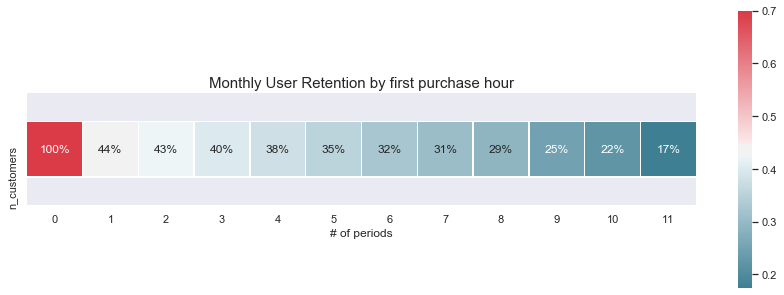

In [46]:
plt.figure(figsize=(15, 17))
trans_cust_cohort = trans_cust_complete.groupby(['cohort', 'order_month_shft']) \
                                        .agg({'customer': 'nunique'}) \
                                        .reset_index(drop=False) \
                                        .rename(columns={'customer':'n_customers'})

trans_cust_cohort['period_number'] = ((trans_cust_cohort.order_month_shft - trans_cust_cohort.cohort).apply(attrgetter('n')))
cohort_pivot = trans_cust_cohort.pivot_table(columns = 'period_number',values = 'n_customers', aggfunc='sum', fill_value=0)
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

ax = sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, fmt='.0%', cmap=cmap, \
            vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
ax.set_title('Average Monthly User Retention Rate', fontsize=15)
ax.set(xlabel='# of periods',ylabel='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [37]:
cmap = sns.diverging_palette(210, 10, as_cmap=True)

def var_check_ret(trans_data):    
    trans_cust_cohort = trans_data.groupby(['cohort', 'order_month_shft']) \
                                       .agg({'customer': 'nunique'}) \
                                       .reset_index(drop=False) \
                                       .rename(columns={'customer':'n_customers'})
    trans_cust_cohort['period_number'] = ((trans_cust_cohort.order_month_shft - trans_cust_cohort.cohort).apply(attrgetter('n')))

    cohort_pivot = trans_cust_cohort.pivot_table(index = 'cohort',columns = 'period_number',values = 'n_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    #Lastly, we plot the retention matrix as a heatmap
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(10, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.0%', 
                    cmap=cmap, 
                    vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                    ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='# of periods',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()

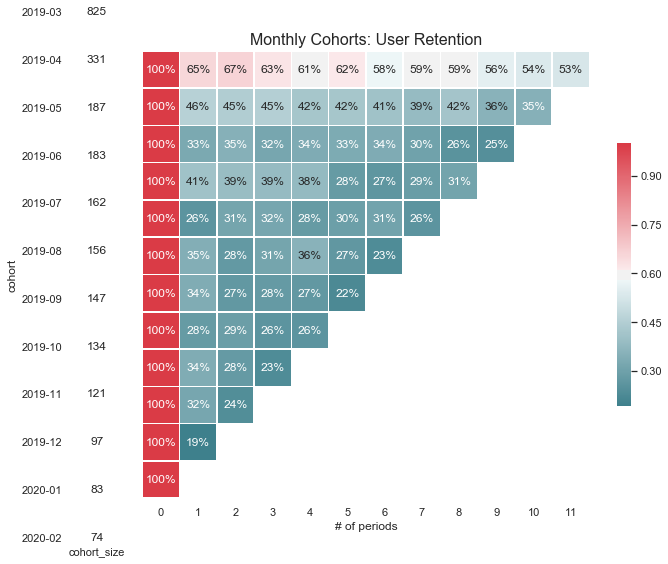

In [38]:
var_check_ret(trans_cust_complete)

In [47]:
def create_ret_matr(trans_cust_complete, feature_str):
    trans_cust_cohort = trans_cust_complete.groupby(['cohort', 'order_month_shft', feature_str]) \
                                        .agg({'customer': 'nunique'}) \
                                        .reset_index(drop=False) \
                                        .rename(columns={'customer':'n_customers'})

    trans_cust_cohort['period_number'] = ((trans_cust_cohort.order_month_shft - trans_cust_cohort.cohort).apply(attrgetter('n')))
    cohort_pivot = trans_cust_cohort.pivot_table(index=feature_str, columns = 'period_number',values = 'n_customers', aggfunc='sum')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    return retention_matrix

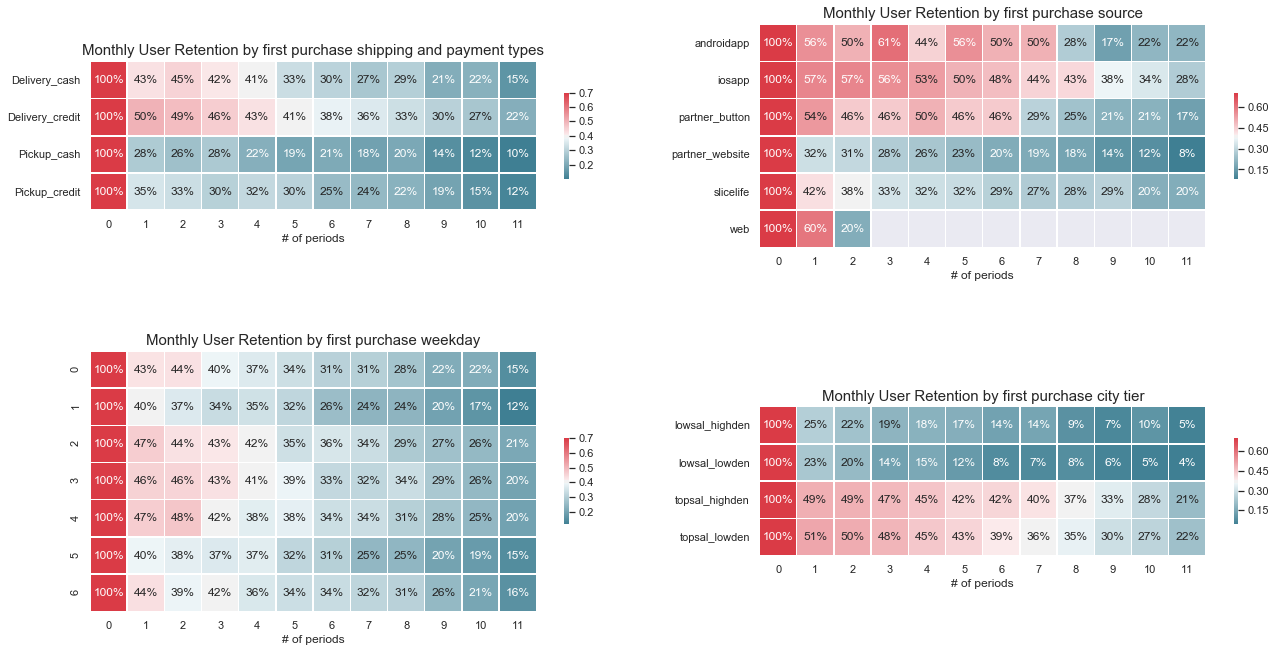

In [48]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f = plt.figure(figsize=(22, 18))
gs = f.add_gridspec(3, 2)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete, 'first_shipping_payment')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase shipping and payment types', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete, 'first_source')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase source', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)


with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete, 'first_order_weekday')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase weekday', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)


with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete, 'first_city_tier')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase city tier', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)



In [52]:
trans_cust_complete.groupby(['promo_value']).agg(promo_cities=('city_x','nunique'))

,promo_cities
promo_value,
0,1153
1,136
2,112
3,121
4,109
5,64


In [53]:
trans_cust_complete.groupby(['promo_value']).agg(order_value=('restaurant_total','median'))

,order_value
promo_value,
0,27.400
1,23.790
2,22.970
3,24.420
4,23.820
5,23.875


In [54]:
city_data = pd.DataFrame(trans_cust_complete.groupby(['promo_value','city_tier']).agg(order_counts=('order_id','count')))
city_data.pivot_table(index='promo_value', columns='city_tier',values='order_counts')

city_tier,lowsal_highden,lowsal_lowden,topsal_highden,topsal_lowden
promo_value,,,,
0,416,1356,6948,15333
1,8,13,49,121
2,6,20,49,88
3,6,25,44,99
4,6,15,43,94
5,2,10,26,34


In [56]:
source_data = pd.DataFrame(trans_cust_complete.groupby(['promo_value','source']).agg(order_counts=('order_id','count')))
source_data.pivot_table(index='promo_value', columns='source',values='order_counts')

source,androidapp,call-center,iosapp,partner_button,partner_website,slicelife,web
promo_value,,,,,,,
0,383.0,2.0,15605.0,88.0,5529.0,2407.0,44.0
1,3.0,NaN,171.0,NaN,8.0,9.0,NaN
2,3.0,NaN,151.0,NaN,4.0,5.0,NaN
3,3.0,NaN,159.0,NaN,5.0,7.0,NaN
4,3.0,NaN,142.0,NaN,7.0,6.0,NaN
5,3.0,NaN,66.0,NaN,NaN,3.0,NaN


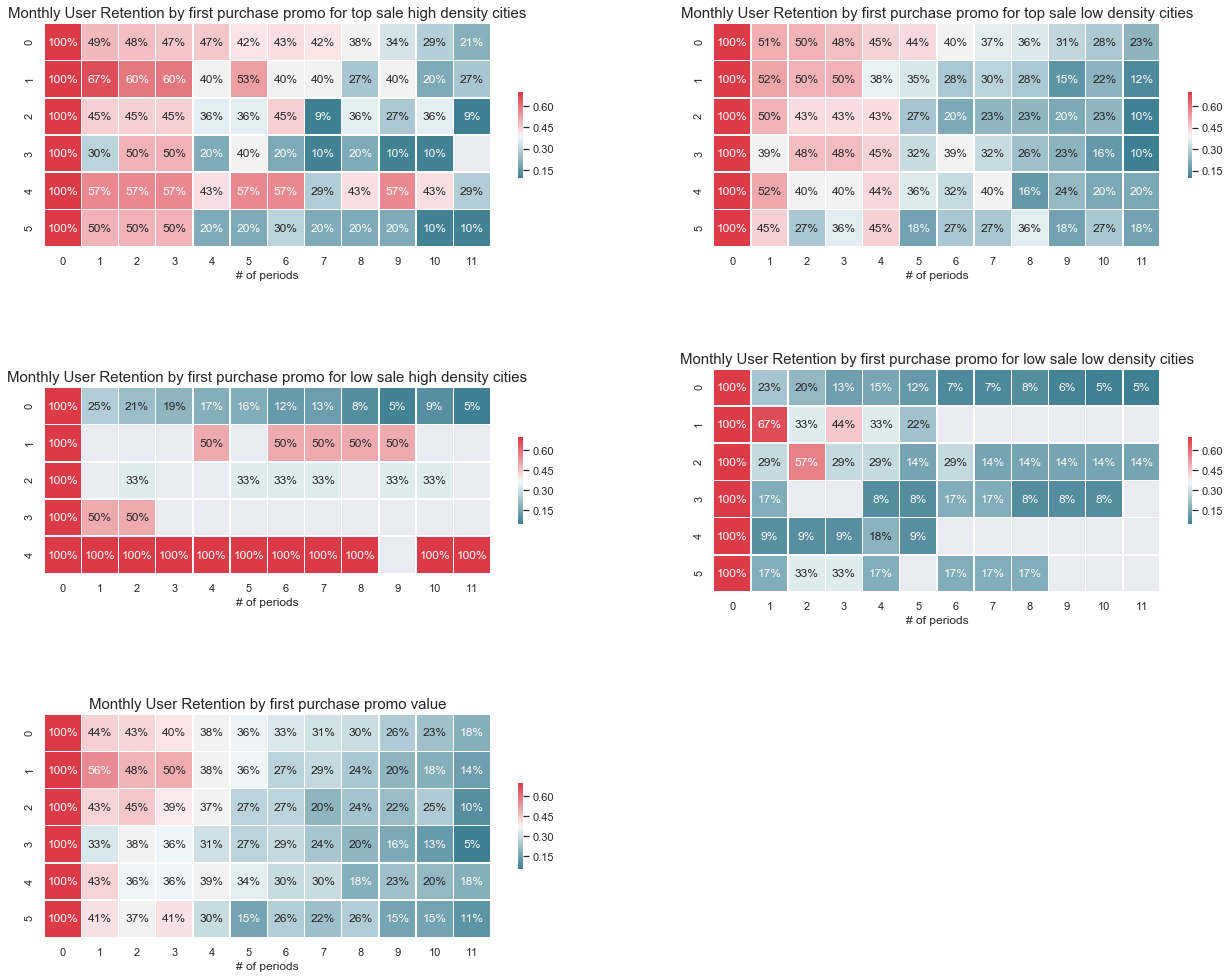

In [57]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f = plt.figure(figsize=(22, 18))
gs = f.add_gridspec(3, 2)


with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete[trans_cust_complete.first_city_tier=='topsal_highden'], 'first_promo_value')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase promo for top sale high density cities', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete[trans_cust_complete.first_city_tier=='topsal_lowden'], 'first_promo_value')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase promo for top sale low density cities', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete[trans_cust_complete.first_city_tier=='lowsal_highden'], 'first_promo_value')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase promo for low sale high density cities', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete[trans_cust_complete.first_city_tier=='lowsal_lowden'], 'first_promo_value')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase promo for low sale low density cities', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[2, 0])
    matrx_first_shipping_payment = create_ret_matr(trans_cust_complete, 'first_promo_value')
    sns.heatmap(matrx_first_shipping_payment, mask=matrx_first_shipping_payment.isnull(), annot=True, fmt='.0%', cmap=cmap, 
                vmax=0.7,square=True, linewidths=.5, cbar_kws={"shrink": .3})
    ax.set_title('Monthly User Retention by first purchase promo value', fontsize=15)
    ax.set(xlabel='# of periods',ylabel='')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    

In [ ]:
def var_check(var_str):
    trans_state = trans_data[['order_id',var_str,'order_month']]

    trans_state_pivot = trans_state.pivot_table(index = var_str, \
                                                columns ='order_month', \
                                                values ='order_id', \
                                                aggfunc='count',\
                                                fill_value=0)
    cust_month = trans_data.groupby([var_str,'customer']) \
                           .agg({'order_month':'min'}) \
                           .reset_index() \
                           .rename(columns={'order_month':'first_month'})

    cust_month_pivot = cust_month.pivot_table(index = var_str, \
                                                columns ='first_month', \
                                                values ='customer', \
                                                aggfunc='count',\
                                                fill_value=0) 
    return cust_month_pivot